In [1]:
import os
import pandas as pd
# supress warnings about having no GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from Humatch.align import get_padded_seq
from Humatch.model import load_cnn
from Humatch.classify import predict_from_list_of_seq_strs, get_class_and_score_of_max_predictions_only
from Humatch.plot import plot_example_boxplot

### Sequence data

Read in example human and non-human heavy and light sequences.

In [2]:
root_dir = os.path.dirname(os.path.abspath(""))
data = os.path.join(root_dir, "data", "example.csv")
df = pd.read_csv(data)
print(df.shape)
df.head(1)

(20, 3)


,is_human,heavy,light
0,1,QVQLVQSGAEVNKPGASVKVSCKASGYTFTGYVVHWVRQAPGQRLE...,EIVLTQSPVTLSLSPGERATLSCRASQSVSFYLAWYQQKPGQAPRL...


### Align sequences

Number sequences with ANARCI and align to the 200 most common positions determined by KASearch.

In [3]:
df["heavy"] = df.apply(lambda x: get_padded_seq(x["heavy"]), axis=1)
df["light"] = df.apply(lambda x: get_padded_seq(x["light"]), axis=1)
df.head(2)

,is_human,heavy,light
0,1,QVQ-LVQSGA-EVNKPGASVKVSCKASGYTF---------TGYVVH...,EIV-LTQSPVTLSLSPGERATLSCRASQSV-----------SFYLA...
1,1,QVQ-LVQSGA-EVKKPGASVKVSCKASGYTF---------TGYYMH...,SYE-LTQPPS-VSVSPGQTARITCSGDALP-----------KQYAY...


### CNN classifiers

Load saved heavy, light, and paired CNN models.

In [4]:
weights_dir = os.path.join(root_dir, "Humatch", "trained_models")

cnn_heavy = load_cnn(os.path.join(weights_dir, "heavy.weights.h5"), "heavy")
cnn_light = load_cnn(os.path.join(weights_dir, "light.weights.h5"), "light")
cnn_paired = load_cnn(os.path.join(weights_dir, "paired.weights.h5"), "paired")

cnn_heavy.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 200, 40)        │         4,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 199, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │     2,388,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,394,748 (9.14 MB)

 Trainable params: 2,394,748 (9.14 MB)

 Non-trainable params: 0 (0.00 B)

### Predict

Use the trained CNNs to get heavy, light, and paired predictions for the example aligned sequences.

In [5]:
pad_len, pad_char = 10, "-"
joined_seqs = [H + pad_char * pad_len + L for H, L in zip(df["heavy"], df["light"])]
predictions_heavy = predict_from_list_of_seq_strs(df["heavy"].tolist(), cnn_heavy)
predictions_light = predict_from_list_of_seq_strs(df["light"].tolist(), cnn_light)
predictions_paired = predict_from_list_of_seq_strs(joined_seqs, cnn_paired)

# add the top human V-gene class and score to the dataframe
df[["top_heavy_class", "top_heavy_score"]] = get_class_and_score_of_max_predictions_only(predictions_heavy, "heavy")
df[["top_light_class", "top_light_score"]] = get_class_and_score_of_max_predictions_only(predictions_light, "light")
df[["top_paired_class", "top_paired_score"]] = get_class_and_score_of_max_predictions_only(predictions_paired, "paired")
df.head(2)

,is_human,heavy,light,top_heavy_class,top_heavy_score,top_light_class,top_light_score,top_paired_class,top_paired_score
0,1,QVQ-LVQSGA-EVNKPGASVKVSCKASGYTF---------TGYVVH...,EIV-LTQSPVTLSLSPGERATLSCRASQSV-----------SFYLA...,hv1,1.0,kv3,1.0,true,0.998781
1,1,QVQ-LVQSGA-EVKKPGASVKVSCKASGYTF---------TGYYMH...,SYE-LTQPPS-VSVSPGQTARITCSGDALP-----------KQYAY...,hv1,0.999703,lv3,1.0,true,1.0


### Plot

Compare the distribution of the top heavy, light, and paired CNN scores for human and non-human sequence.

The heavy and light CNNs accurately separate the human and non-human sequences. The paired CNN was trained on true paired human, and artificially `badly' paired human sequences, so the results on non-human sequences are less meaningful.

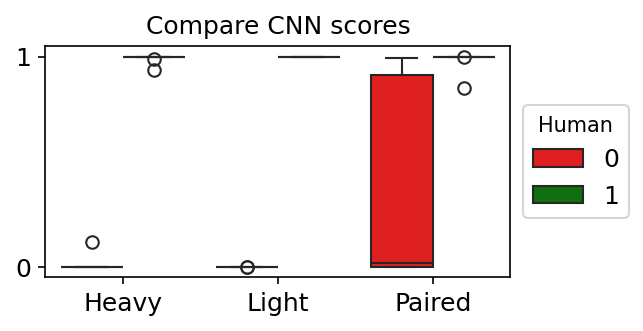

In [6]:
plot_example_boxplot(df)